In [1]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.ts_reader import MultiModalDataset, collate_fn_pre_train
from model.autoencoder_ts import TimeSeriesAutoencoder, LSTMTFAutoencoder,TransformerEncoderDecoder
from pre_train_autoencoder import train_model, test_model, visualize_reconstruction, generate_mask,masked_mae_loss,calculate_correlation,overfit_model

import gc
gc.collect()

import torch
torch.cuda.empty_cache()

In [2]:
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

lstm_loader_train = DataLoader(lstm_dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn_pre_train)
lstm_loader_val = DataLoader(lstm_dataset_val, batch_size=32, shuffle=False,collate_fn=collate_fn_pre_train)
lstm_loader_test = DataLoader(lstm_dataset_test, batch_size=32, shuffle=False,collate_fn=collate_fn_pre_train)

In [ ]:
best_config = {
    "input_dim": 324,
    "hidden_dim": 32,
    "lr": 0.0001,
    "epochs": 10,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = TimeSeriesAutoencoder(
    input_dim=best_config["input_dim"],
    hidden_dim=best_config["hidden_dim"]).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(lstm_model.parameters(), lr=best_config["lr"])

In [ ]:
train_model(lstm_model, lstm_loader_train, lstm_loader_val, criterion, optimizer, best_config, device)

In [ ]:
best_model_path = "/home/mei/nas/docker/thesis/data/model/pre_train_autoencoder/best_model_32_1e-4.pth"
lstm_model.load_state_dict(torch.load(best_model_path,weights_only=True))
lstm_model.eval()
test_model(lstm_model, lstm_loader_test, criterion, device)

In [ ]:
visualize_reconstruction(lstm_model, lstm_loader_test, device,feature_indices=[1])

## overfit model

In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(lstm_loader_train) 
inputs, lengths = next(small_data_iter)  

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [4]:
best_config = {
    "input_dim": 324,
    "hidden_dim": 32,
    "lr": 0.0001,
    "epochs": 10,
    "num_layers": 4,
    "num_heads": 1,
    "num_epochs": 500,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = TimeSeriesAutoencoder(
    input_dim=best_config["input_dim"],
    hidden_dim=best_config["hidden_dim"],   
    num_layers=best_config["num_layers"],
    num_heads=best_config["num_heads"]).to(device)

optimizer = optim.Adam(lstm_model.parameters(), lr=best_config["lr"])

In [5]:
## hidden state as decoder input
overfit_model(lstm_model, best_config["num_epochs"],small_train_loader, optimizer, device,hidden=True,attention=False,teacher_forcing=False,transformer=False)


Epoch 50, Loss: 0.266283,Correlation: 0.074560
Epoch 100, Loss: 0.242914,Correlation: 0.190361
Epoch 150, Loss: 0.188903,Correlation: 0.471182
Epoch 200, Loss: 0.115970,Correlation: 0.702939
Epoch 250, Loss: 0.072983,Correlation: 0.817011
Epoch 300, Loss: 0.050750,Correlation: 0.869492
Epoch 350, Loss: 0.041115,Correlation: 0.887858
Epoch 400, Loss: 0.037070,Correlation: 0.892517
Epoch 450, Loss: 0.035311,Correlation: 0.893025
Epoch 500, Loss: 0.034970,Correlation: 0.891463


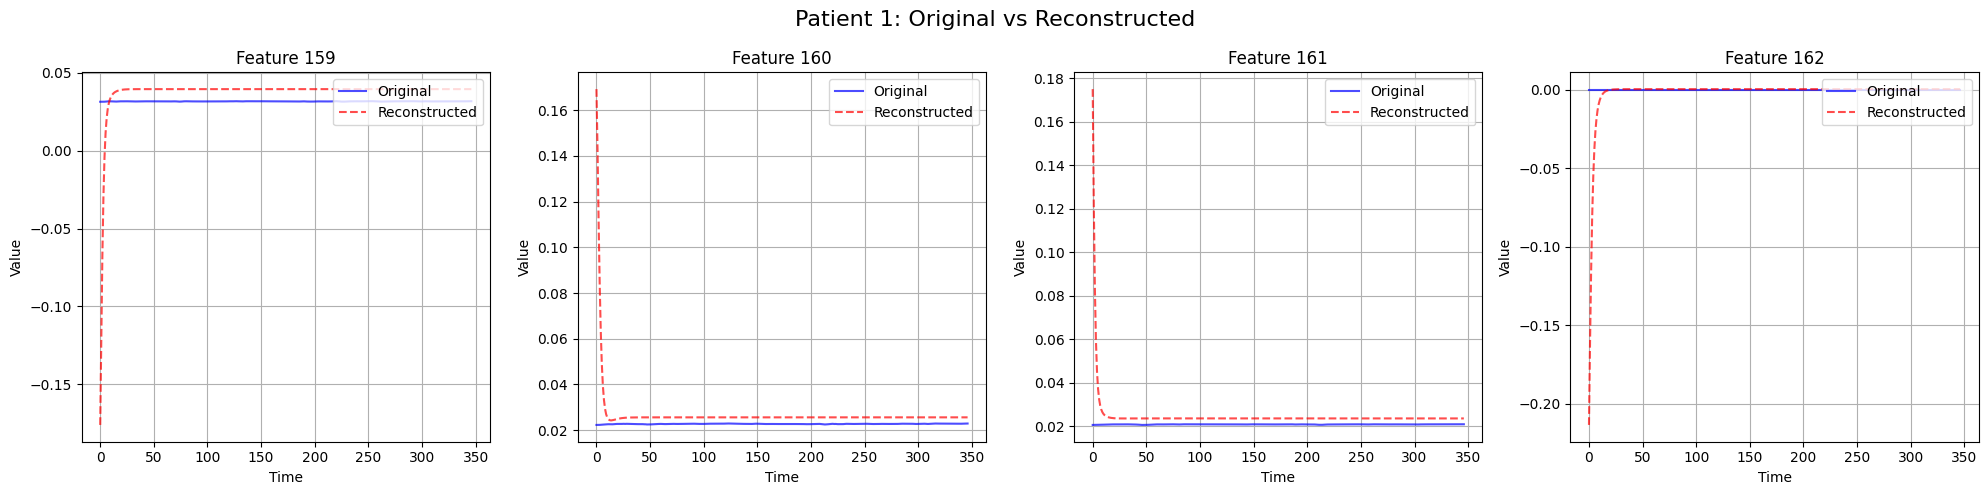

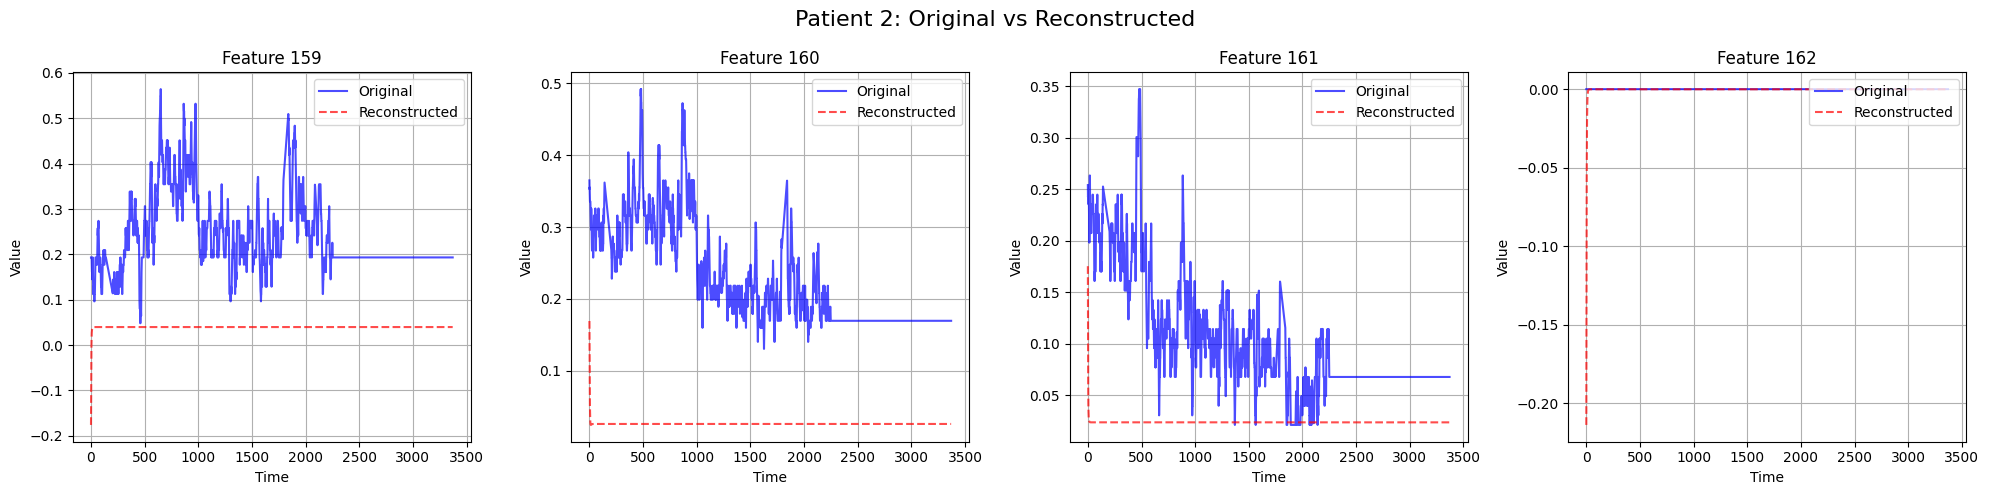

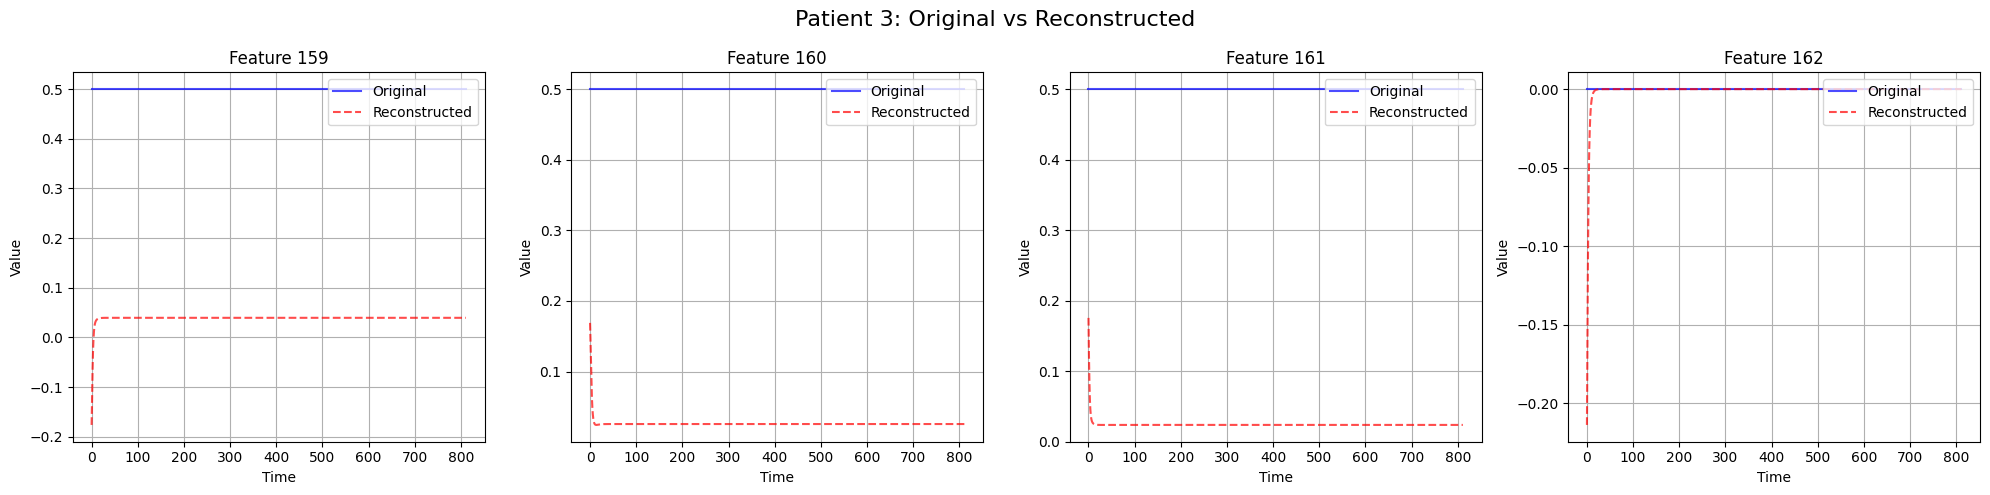

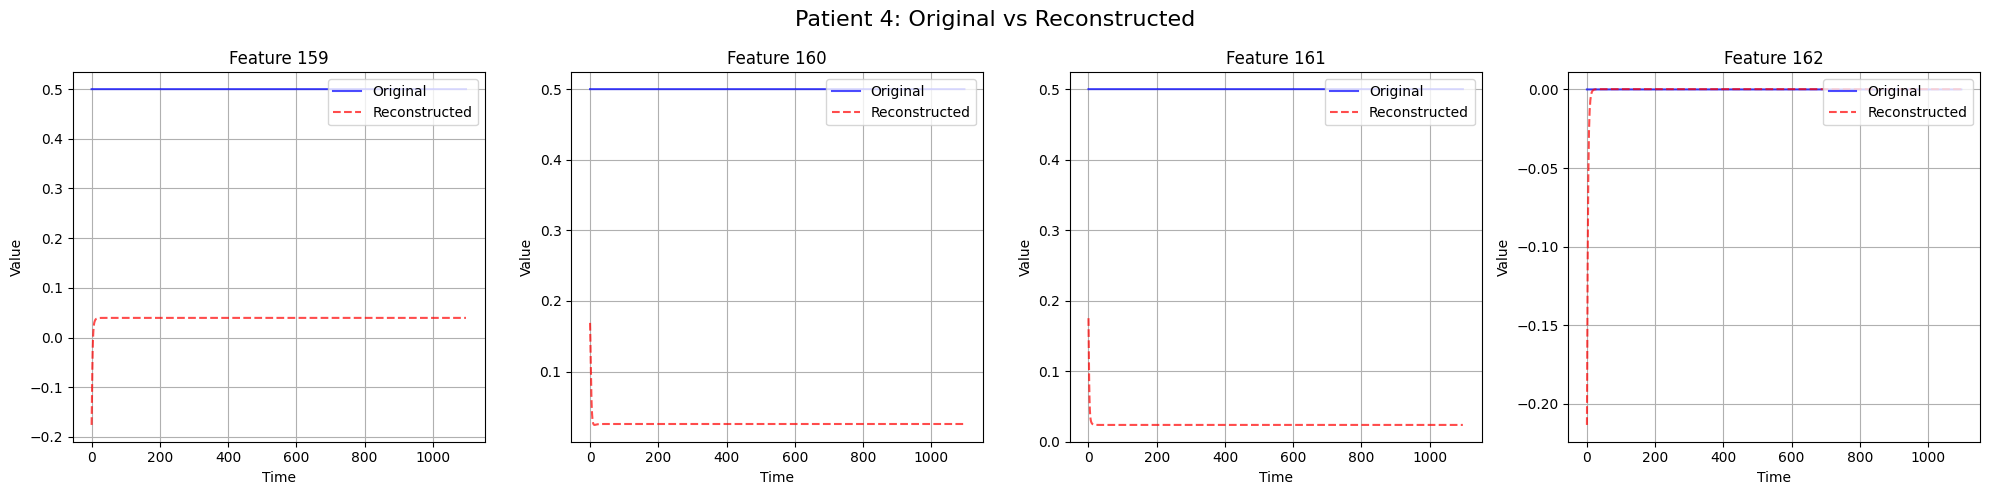

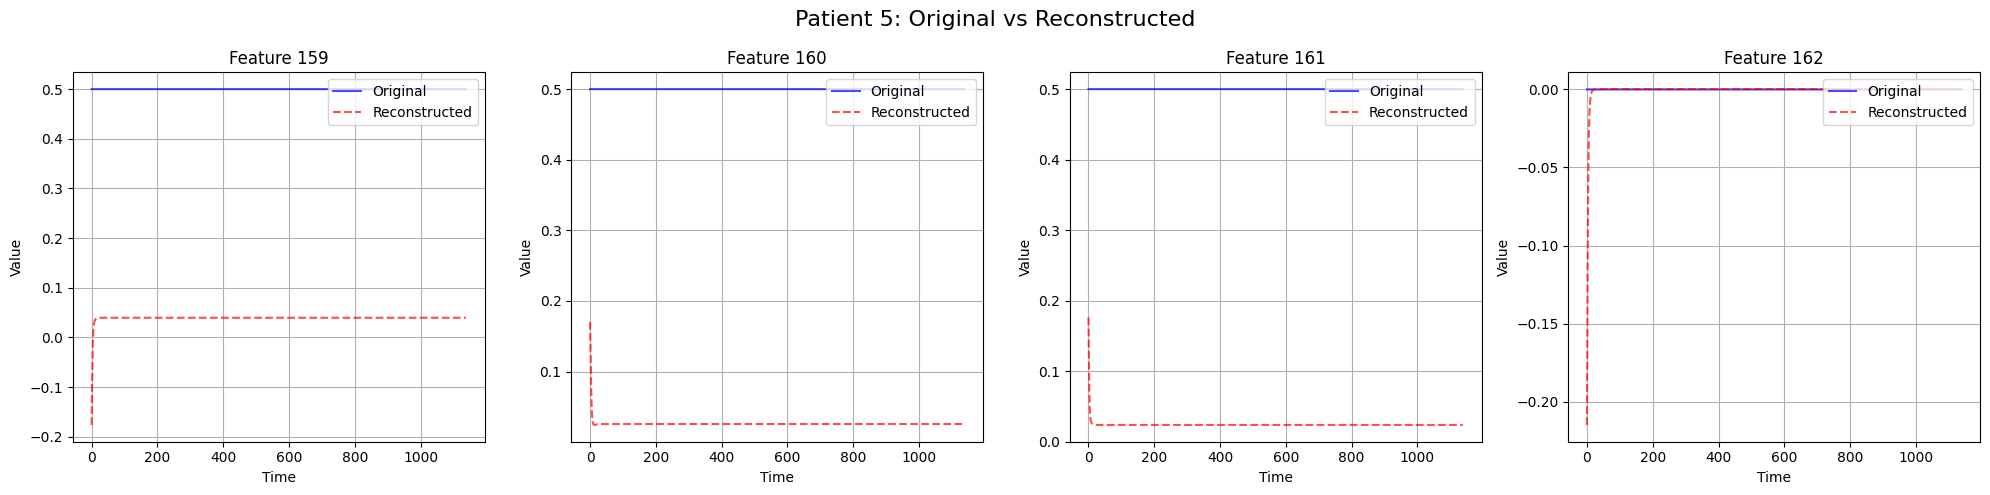

In [6]:
visualize_reconstruction(lstm_model, 
                         small_train_loader, device, num_samples=5,
                         feature_indices=[159,160,161,162])

## add attention layer

In [7]:
best_config = {
    "input_dim": 324,
    "hidden_dim": 32,
    "lr": 0.0001,
    "epochs": 10,
    "num_layers": 4,
    "num_heads": 1,
    "num_epochs": 500,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attention_model = TimeSeriesAutoencoder(
    input_dim=best_config["input_dim"],
    hidden_dim=best_config["hidden_dim"],   
    num_layers=best_config["num_layers"],
    num_heads=best_config["num_heads"]).to(device)

optimizer = optim.Adam(attention_model.parameters(), lr=best_config["lr"])

In [8]:
overfit_model(attention_model, best_config["num_epochs"],small_train_loader, optimizer, device,hidden=False,attention=True,teacher_forcing=False,transformer=False)

Epoch 50, Loss: 0.267680,Correlation: 0.056612
Epoch 100, Loss: 0.247734,Correlation: 0.156648
Epoch 150, Loss: 0.206823,Correlation: 0.385166
Epoch 200, Loss: 0.142548,Correlation: 0.609816
Epoch 250, Loss: 0.092324,Correlation: 0.749647
Epoch 300, Loss: 0.064036,Correlation: 0.824368
Epoch 350, Loss: 0.050434,Correlation: 0.860825
Epoch 400, Loss: 0.042995,Correlation: 0.878123
Epoch 450, Loss: 0.038838,Correlation: 0.885444
Epoch 500, Loss: 0.036471,Correlation: 0.888358


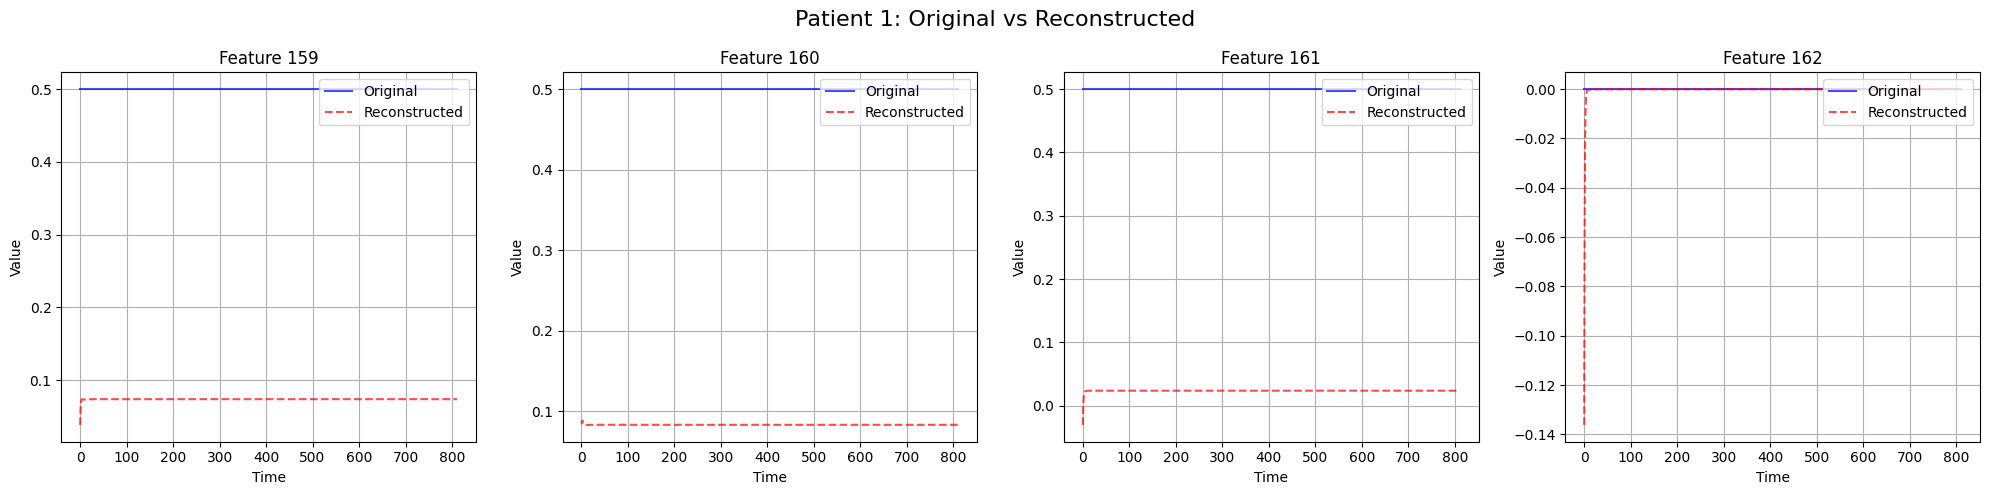

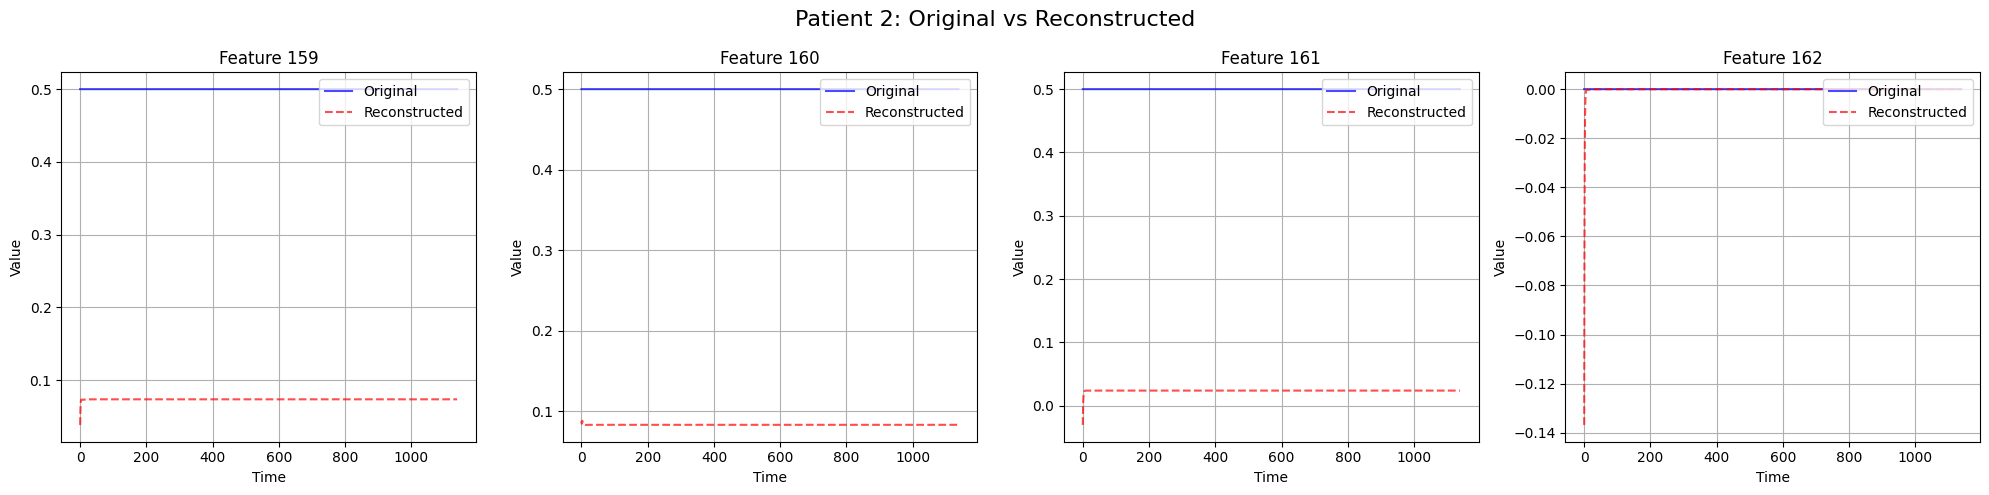

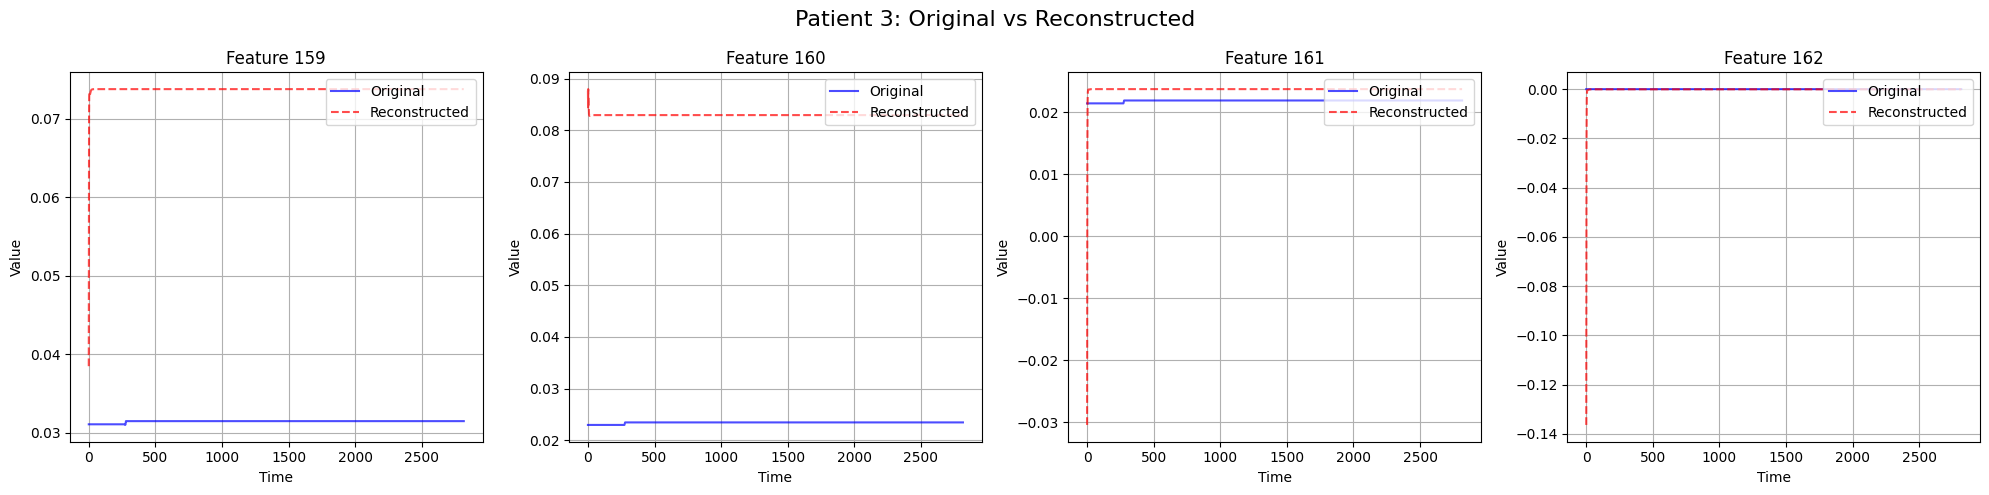

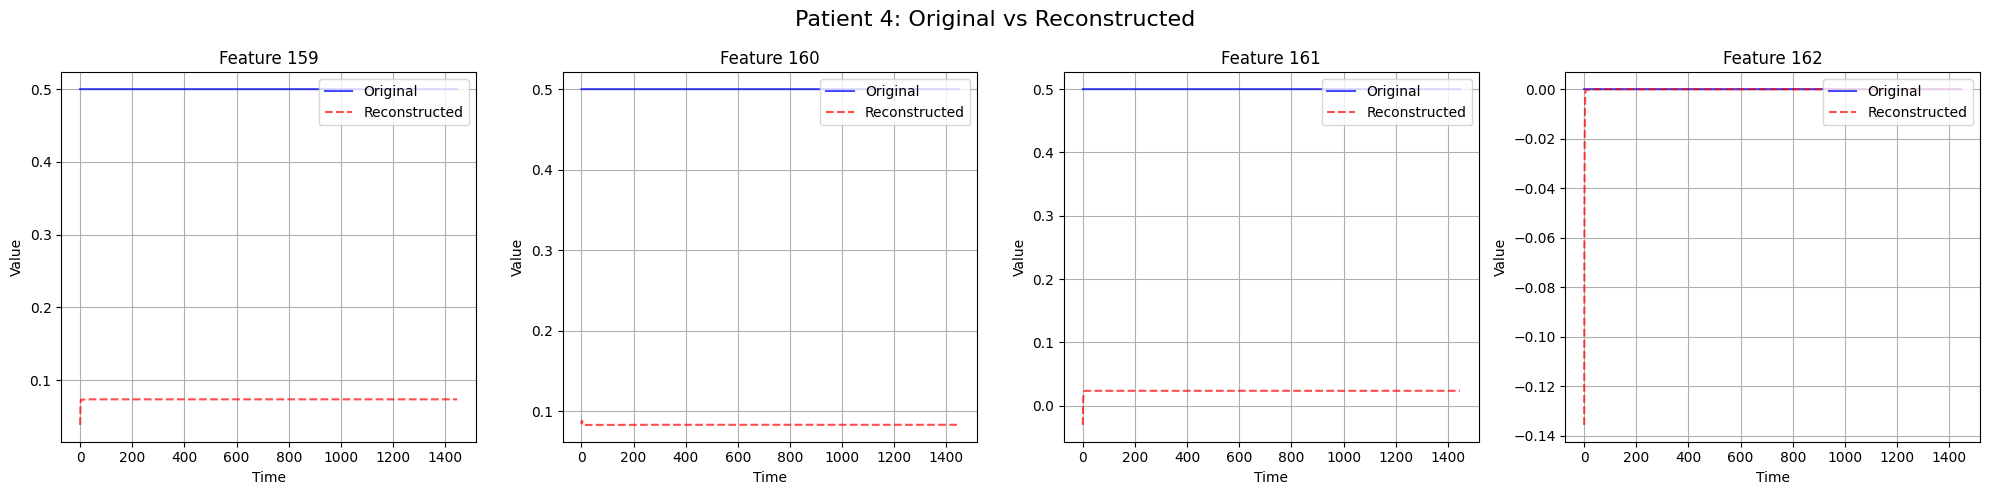

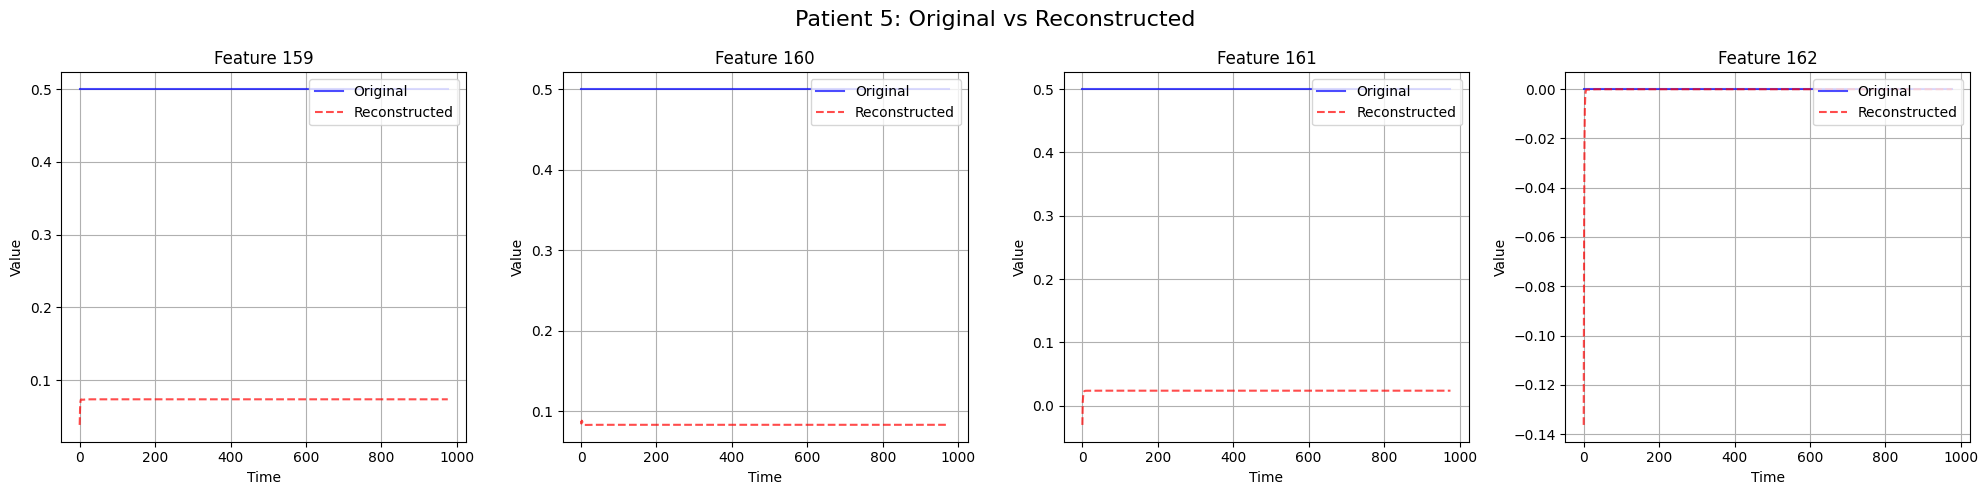

In [9]:
visualize_reconstruction(attention_model, 
                         small_train_loader, device, num_samples=5,
                         feature_indices=[159,160,161,162])

## teacher forcing

In [4]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(lstm_loader_train) 
inputs, lengths = next(small_data_iter)  

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [10]:
input_dim = 324
hidden_dim = 32
num_layers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tf_model = LSTMTFAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(tf_model.parameters(), lr=0.0001)

In [11]:
overfit_model(tf_model, best_config["num_epochs"],small_train_loader, optimizer, device,hidden=False,attention=False,teacher_forcing=True,transformer=False)

Epoch 50, Loss: 0.254174,Correlation: 0.094610
Epoch 100, Loss: 0.224932,Correlation: 0.292871
Epoch 150, Loss: 0.172501,Correlation: 0.532250
Epoch 200, Loss: 0.115223,Correlation: 0.699001
Epoch 250, Loss: 0.075597,Correlation: 0.803378
Epoch 300, Loss: 0.053798,Correlation: 0.856007
Epoch 350, Loss: 0.042461,Correlation: 0.880535
Epoch 400, Loss: 0.037642,Correlation: 0.889402
Epoch 450, Loss: 0.036164,Correlation: 0.892896
Epoch 500, Loss: 0.035327,Correlation: 0.894213


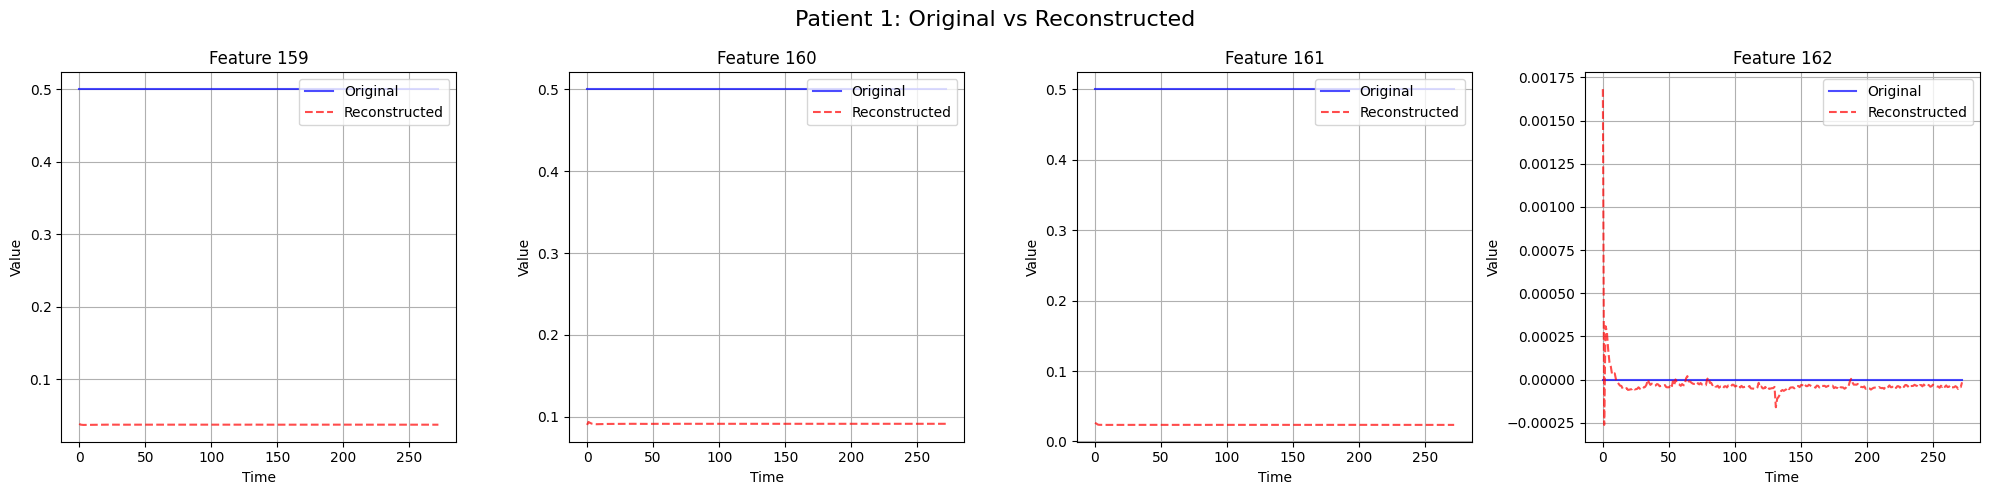

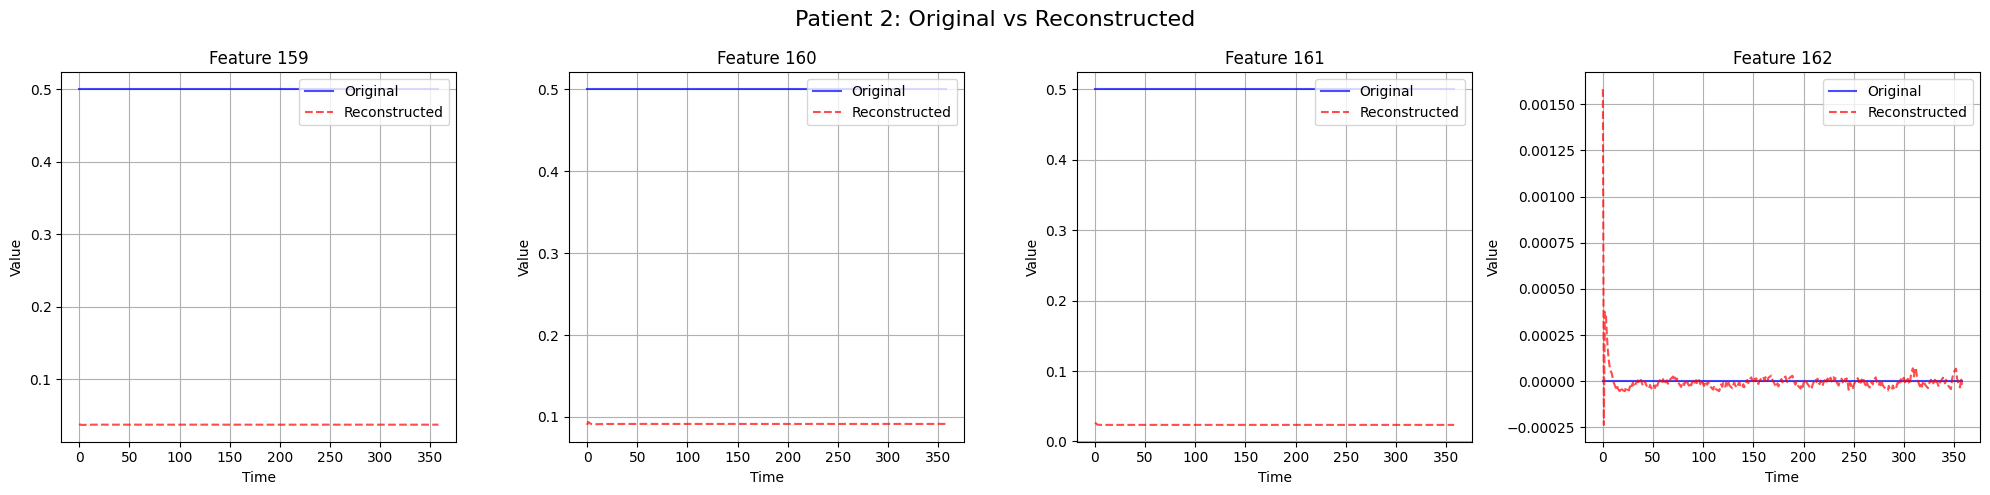

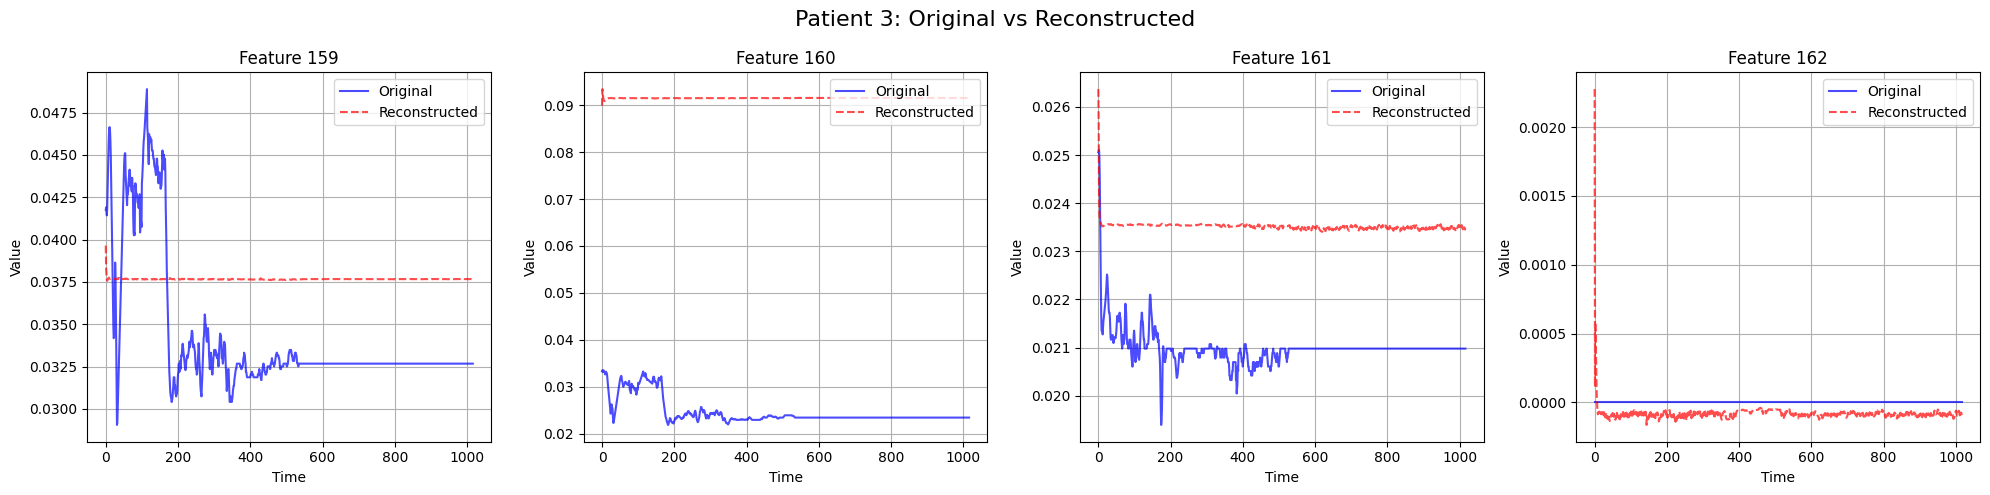

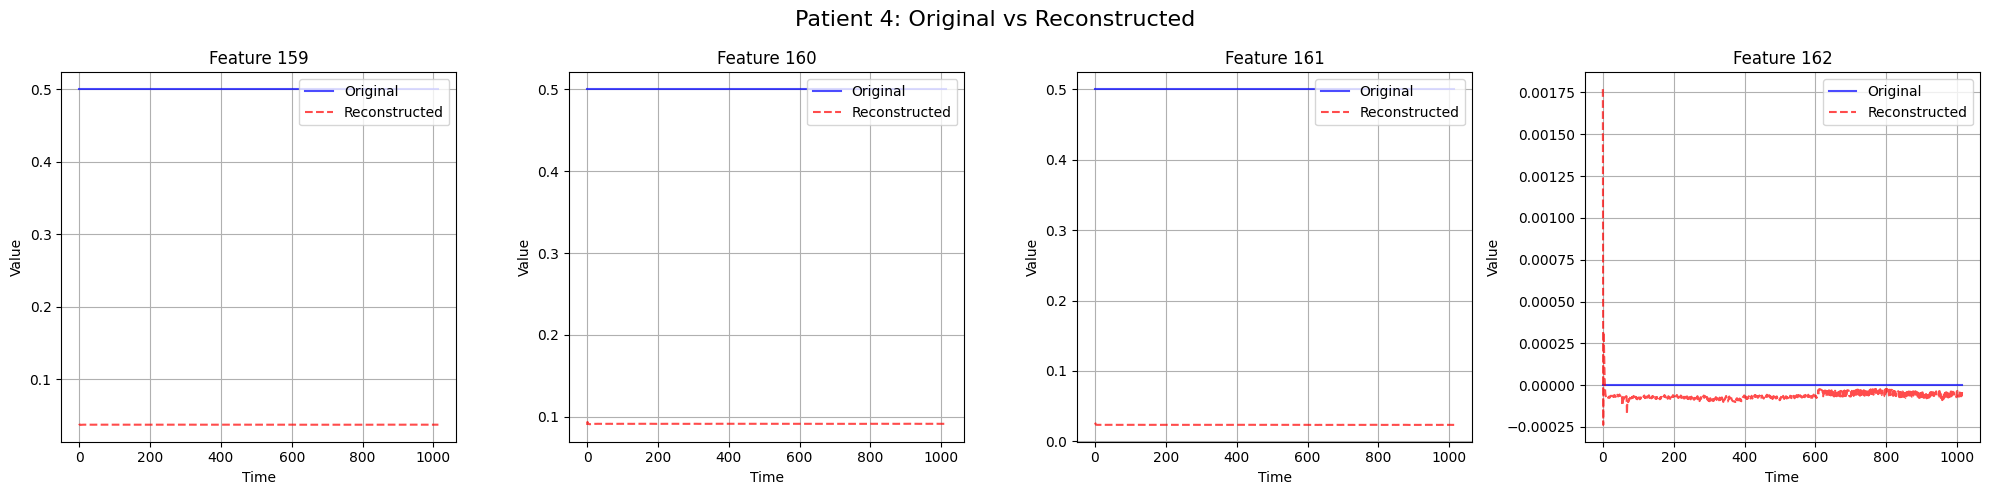

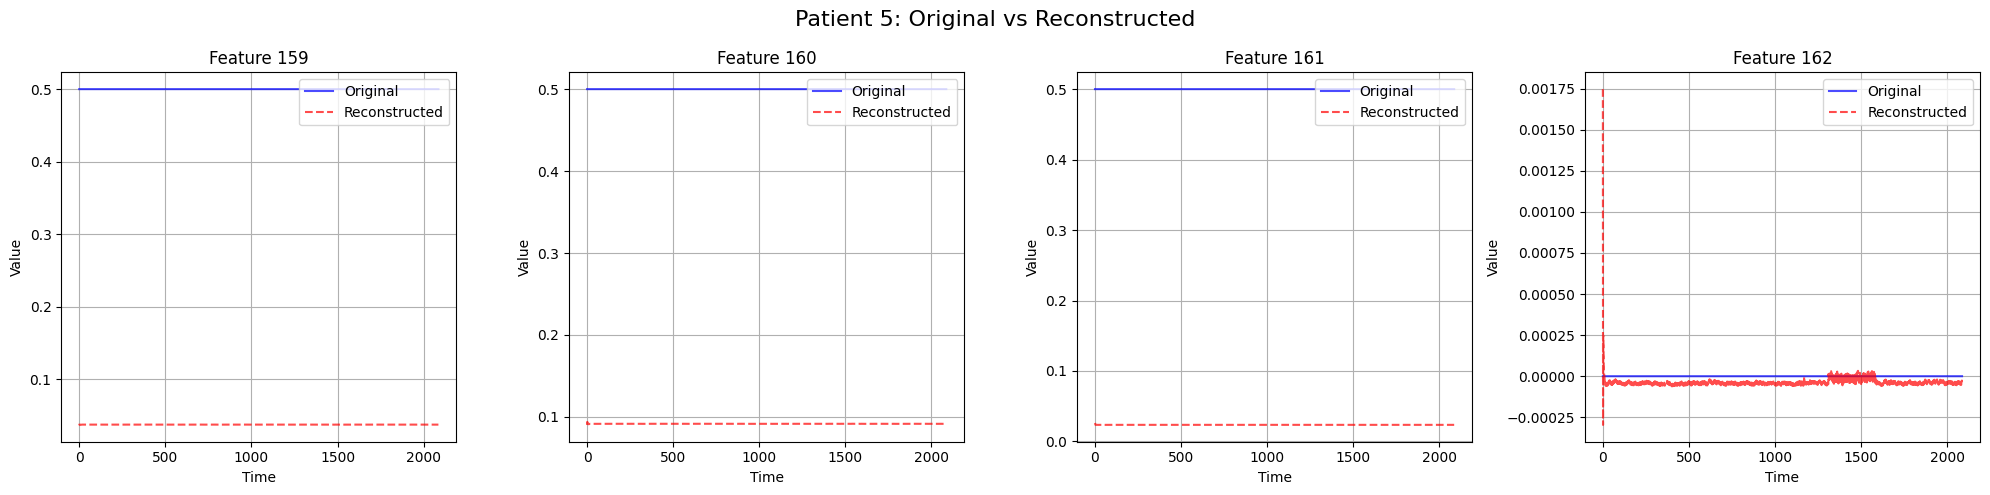

In [12]:
visualize_reconstruction(tf_model, small_train_loader, device, num_samples=5,feature_indices=[159,160,161,162],transformer=False)

## transformer as encoder decoder model

In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(lstm_loader_train) 
inputs, lengths = next(small_data_iter)  

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [ ]:
input_dim = 324 
d_model = 64   
nhead = 4       
num_encoder_layers = 3  
num_decoder_layers = 3 
dim_feedforward = 128   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerEncoderDecoder(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
overfit_model(model, best_config["num_epochs"],small_train_loader, optimizer, device,hidden=False,attention=False,teacher_forcing=False,transformer=True)


Epoch 50, Loss: 0.237652,Correlation: 0.405112
Epoch 100, Loss: 0.133526,Correlation: 0.699354
Epoch 150, Loss: 0.091632,Correlation: 0.840893
Epoch 200, Loss: 0.079400,Correlation: 0.873218
Epoch 250, Loss: 0.074975,Correlation: 0.877514
Epoch 300, Loss: 0.072082,Correlation: 0.880235
Epoch 350, Loss: 0.069791,Correlation: 0.882461
Epoch 400, Loss: 0.067639,Correlation: 0.884296
Epoch 450, Loss: 0.065797,Correlation: 0.885763
Epoch 500, Loss: 0.064028,Correlation: 0.887232


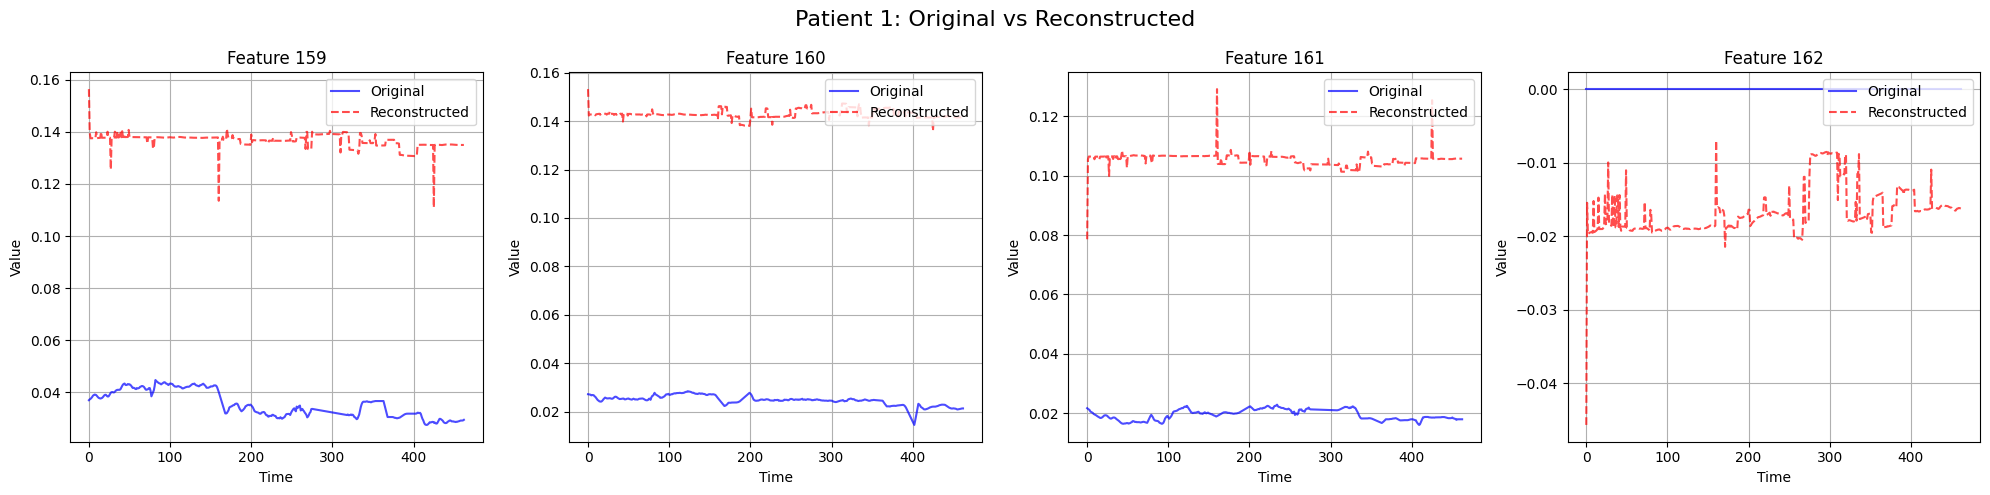

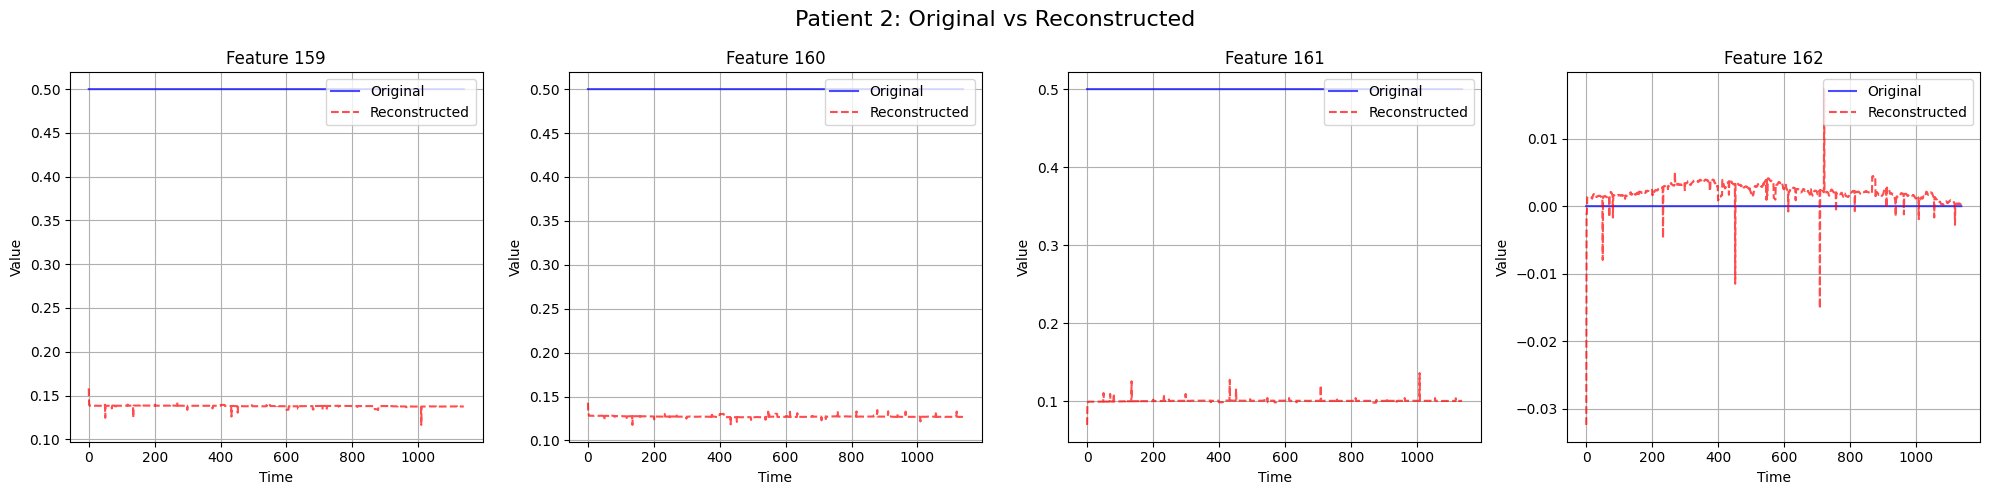

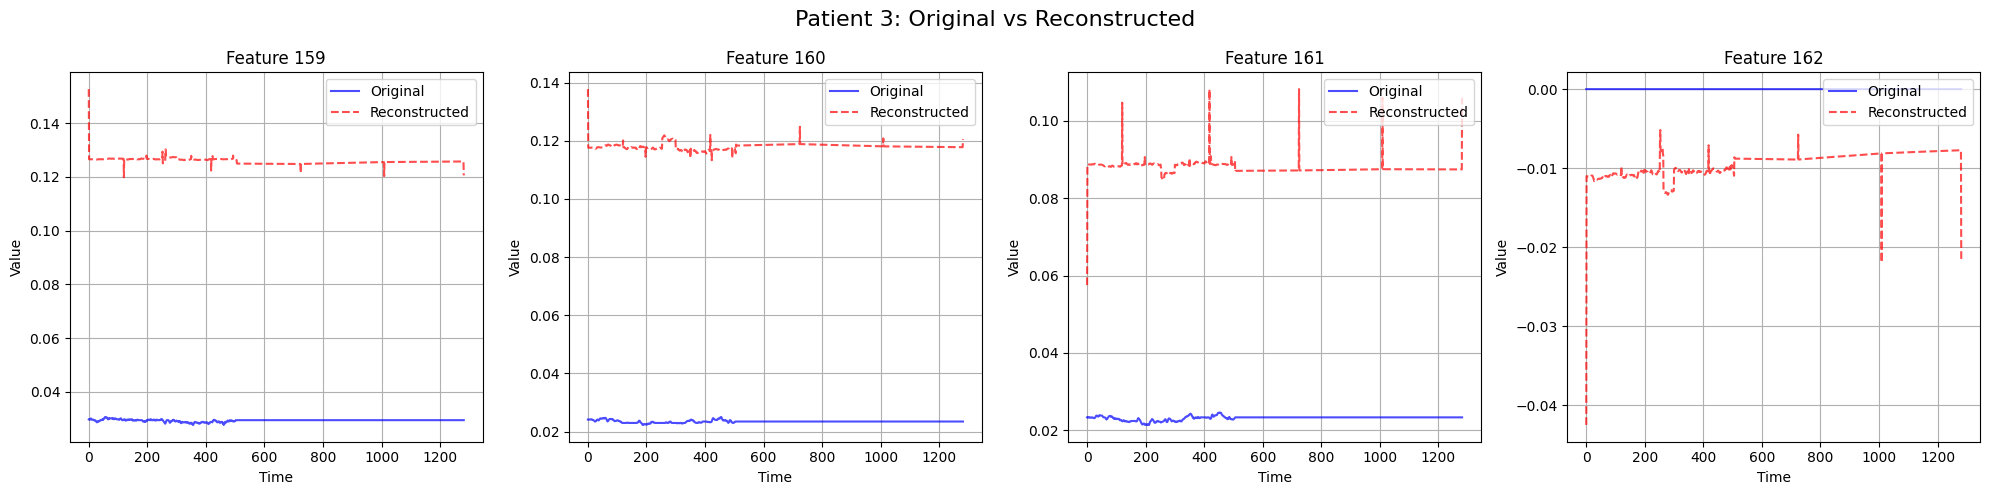

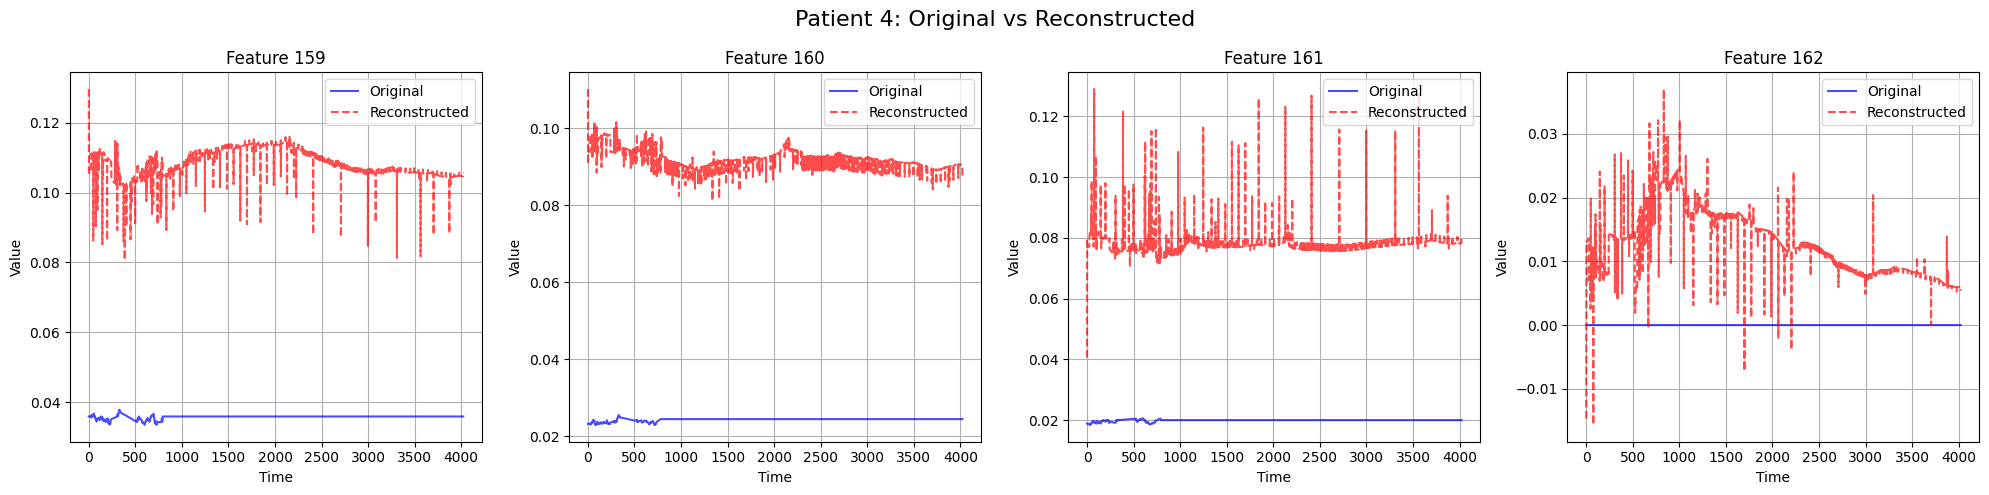

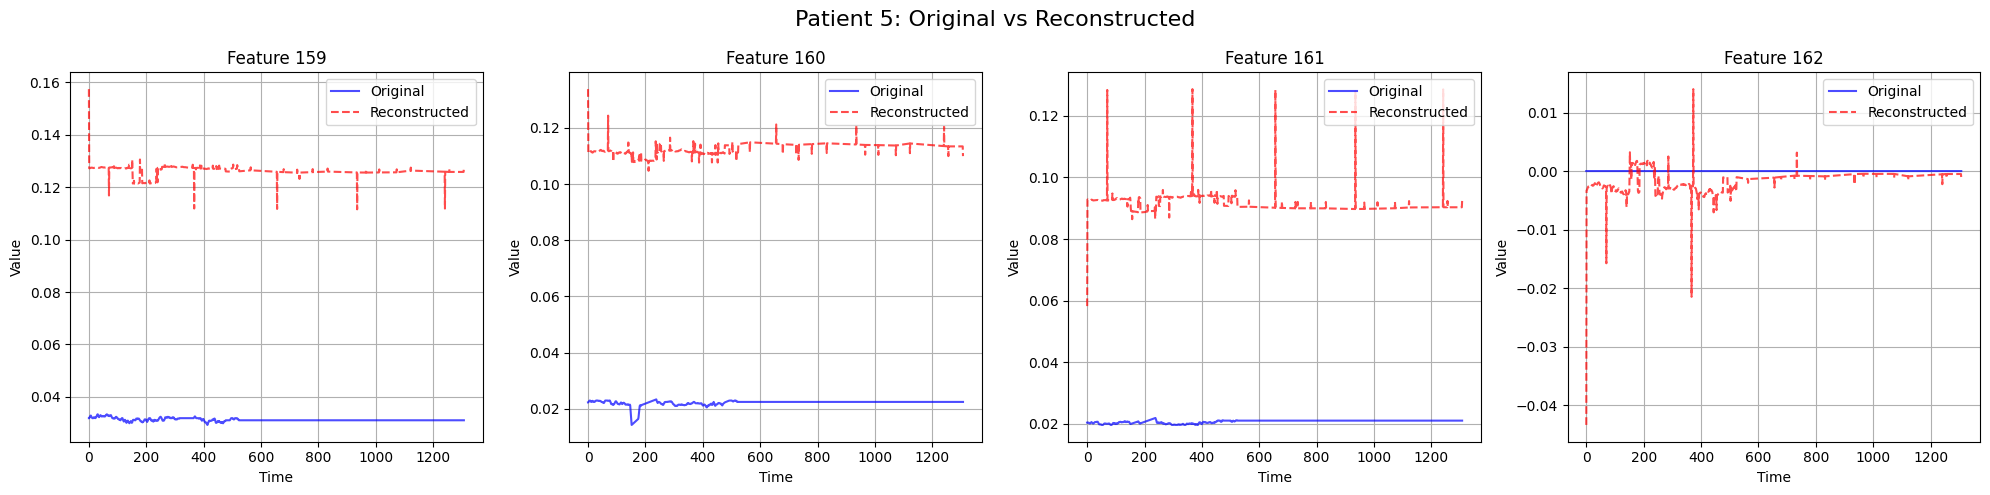

In [15]:
visualize_reconstruction(model, small_train_loader, device, num_samples=5,feature_indices=[159,160,161,162],transformer=True)